In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [192]:
coin="ADA-USD"
df=pd.read_csv("{}.csv".format(coin))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.025160,0.035060,0.025006,0.032053,0.032053,18716200
1,2017-11-10,0.032219,0.033348,0.026451,0.027119,0.027119,6766780
2,2017-11-11,0.026891,0.029659,0.025684,0.027437,0.027437,5532220
3,2017-11-12,0.027480,0.027952,0.022591,0.023977,0.023977,7280250
4,2017-11-13,0.024364,0.026300,0.023495,0.025808,0.025808,4419440


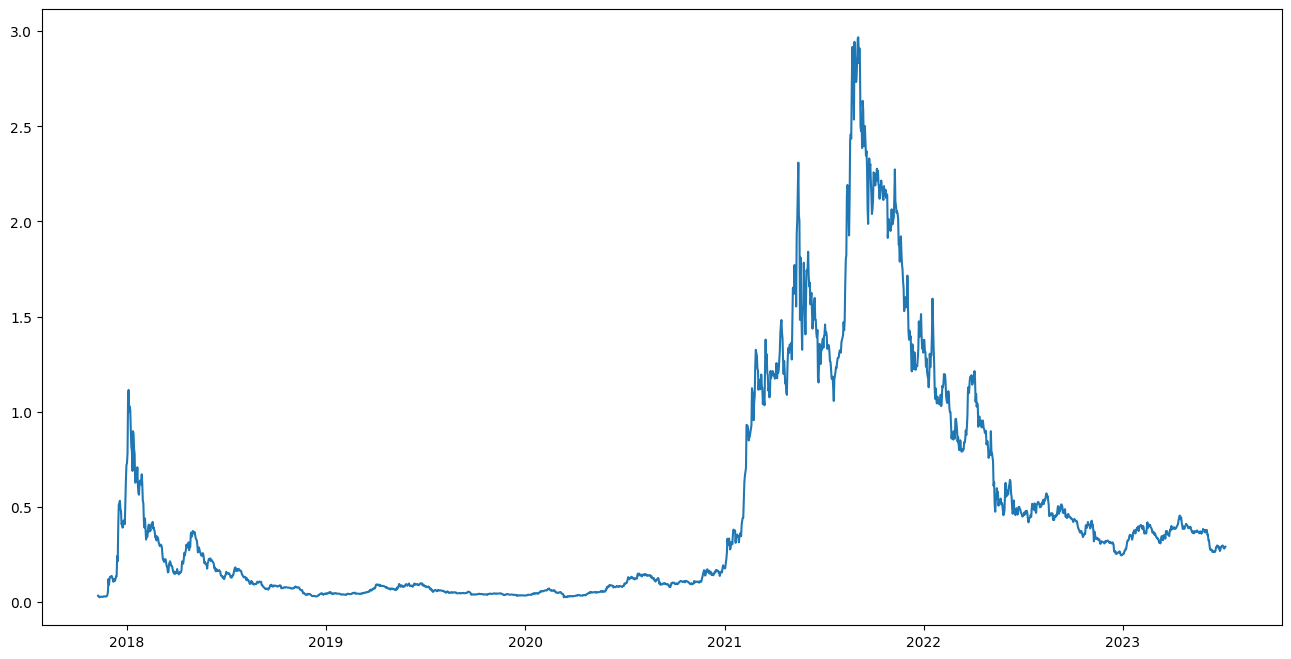

In [193]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [194]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [195]:
training_ratio=0.8
training_size=int(len(new_dataset)*training_ratio)

In [196]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values
train_data=final_dataset[0:training_size,:]
valid_data=final_dataset[training_size:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [197]:
x_train_data

array([[[2.74838178e-03],
        [1.07258893e-03],
        [1.18059504e-03],
        ...,
        [3.31353901e-01],
        [3.40724959e-01],
        [3.34397431e-01]],

       [[1.07258893e-03],
        [1.18059504e-03],
        [5.43426945e-06],
        ...,
        [3.40724959e-01],
        [3.34397431e-01],
        [2.97200536e-01]],

       [[1.18059504e-03],
        [5.43426945e-06],
        [6.27318480e-04],
        ...,
        [3.34397431e-01],
        [2.97200536e-01],
        [2.68582654e-01]],

       ...,

       [[2.97912765e-01],
        [2.89758983e-01],
        [3.03239368e-01],
        ...,
        [1.94797842e-01],
        [1.80945889e-01],
        [1.88200978e-01]],

       [[2.89758983e-01],
        [3.03239368e-01],
        [3.23501721e-01],
        ...,
        [1.80945889e-01],
        [1.88200978e-01],
        [1.63589851e-01]],

       [[3.03239368e-01],
        [3.23501721e-01],
        [3.68009067e-01],
        ...,
        [1.88200978e-01],
        [1.6358

In [198]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1594/1594 - 31s - loss: 0.0025 - 31s/epoch - 20ms/step


In [199]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

13/13 [==============================] - 1s 16ms/step


In [200]:
lstm_model.save("{}.h5".format(coin))

C:\Users\ELCA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\ELCA\AppData\Local\Temp\ipykernel_17620\1166615615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


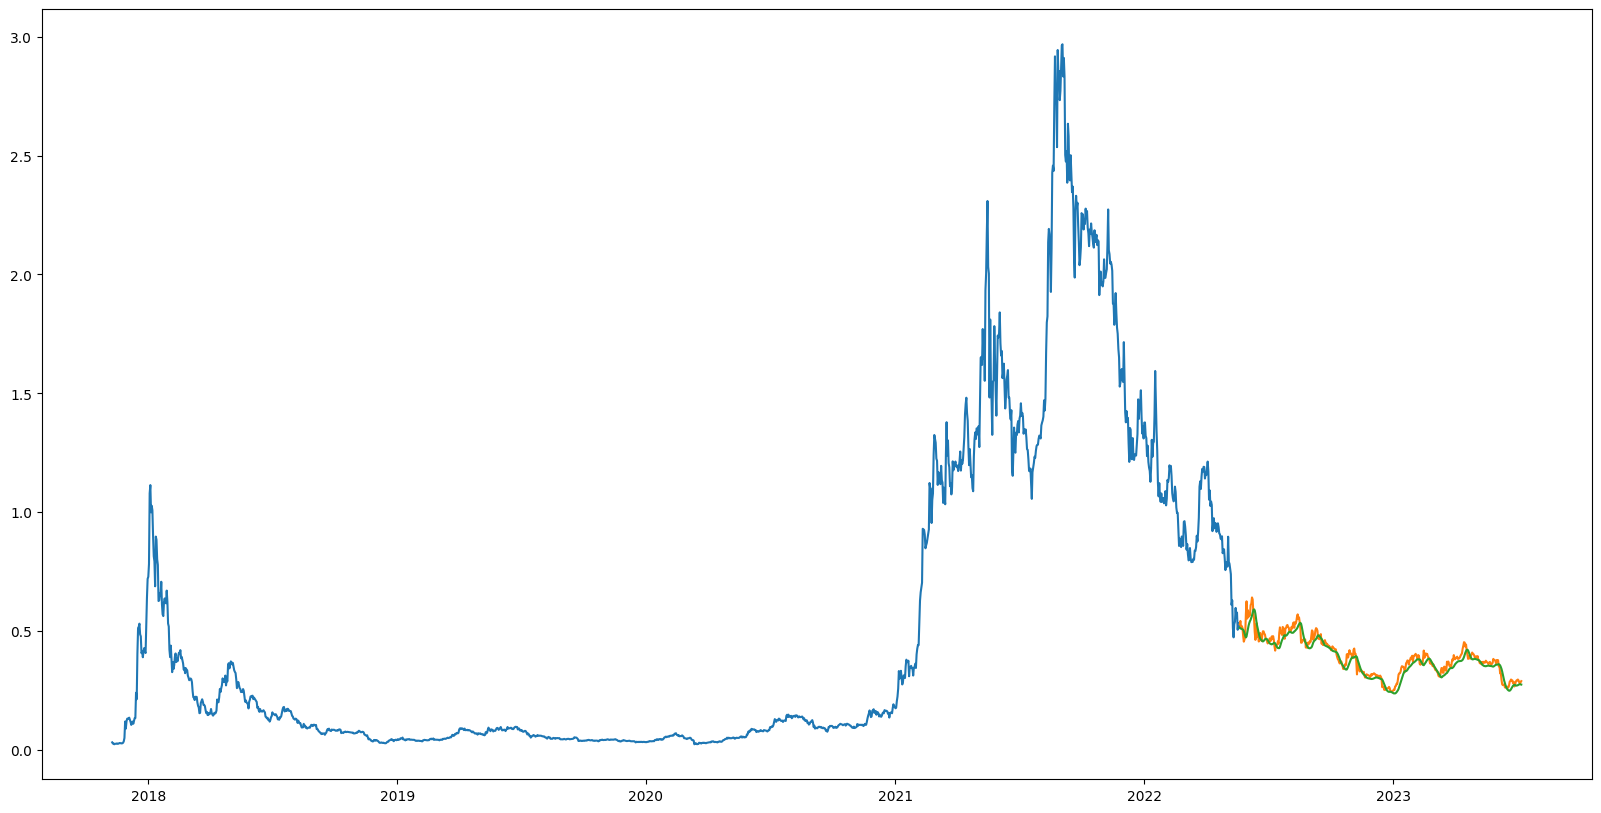

In [201]:
train_data=new_dataset[:training_size]
valid_data=new_dataset[training_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
